# Importing the libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, utils
from tensorflow import keras

import sys
sys.path.insert(0, '../../')
from plot_graphs import plot_loss, plot_acc

# Set image size, batch size, and import dataset

In [2]:
IMAGE_SIZE = 100
BATCH_SIZE = 32

train = utils.image_dataset_from_directory("../../datasets/data/split/Zenodo/train/", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
val = utils.image_dataset_from_directory("../../datasets/data/split/Zenodo/val", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)
test = utils.image_dataset_from_directory("../../datasets/data/split/Zenodo/test", image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE)

Found 3360 files belonging to 6 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 720 files belonging to 6 classes.
Found 720 files belonging to 6 classes.


2022-08-07 17:44:28.334086: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-07 17:44:28.334189: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Train all except the first two conv2d layers

In [3]:
vtid = keras.models.load_model('../../models/vtid2/m2_medium.h5')
vtid.trainable = False

for layer in vtid.layers[6:]:
  layer.trainable = True

x = vtid.layers[-2].output
outputs = layers.Dense(6, activation='softmax', name='classifier')(x)
model = keras.Model(vtid.inputs, outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                         

In [4]:

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=8
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="../../models/transfer/transfer_medium_trainHalf.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [5]:
history = model.fit(
  train.cache(),
  epochs=50,
  callbacks=callbacks_list,
  validation_data=val.cache()
)

Epoch 1/50


2022-08-07 17:44:28.985808: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-07 17:44:28.985886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 1.1379 - accuracy: 0.5726

2022-08-07 17:44:32.379645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 4s 32ms/step - loss: 1.1379 - accuracy: 0.5726 - val_loss: 0.7277 - val_accuracy: 0.7194
Epoch 2/50
105/105 [==============================] - 3s 25ms/step - loss: 0.6783 - accuracy: 0.7565 - val_loss: 0.5362 - val_accuracy: 0.7903
Epoch 3/50
105/105 [==============================] - 3s 27ms/step - loss: 0.5057 - accuracy: 0.8223 - val_loss: 0.4657 - val_accuracy: 0.8208
Epoch 4/50
105/105 [==============================] - 3s 24ms/step - loss: 0.3972 - accuracy: 0.8610 - val_loss: 0.4274 - val_accuracy: 0.8333
Epoch 5/50
105/105 [==============================] - 3s 24ms/step - loss: 0.3153 - accuracy: 0.8890 - val_loss: 0.4042 - val_accuracy: 0.8514
Epoch 6/50
105/105 [==============================] - 3s 25ms/step - loss: 0.2549 - accuracy: 0.9125 - val_loss: 0.3674 - val_accuracy: 0.8681
Epoch 7/50
105/105 [==============================] - 3s 24ms/step - loss: 0.2043 - accuracy: 0.9345 - val_loss: 0.3531 - val_accuracy: 0.8681
Epoch 8/50

In [6]:
model = keras.models.load_model("../../models/transfer/transfer_medium_trainHalf.h5")
model.evaluate(test)

 7/23 [========>.....................] - ETA: 0s - loss: 0.2548 - accuracy: 0.9241

2022-08-07 17:45:40.914927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 17ms/step - loss: 0.3000 - accuracy: 0.9167


[0.3000018298625946, 0.9166666865348816]

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/pyplot.py'>

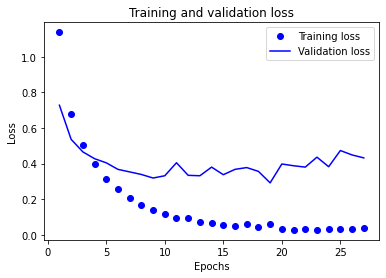

In [7]:
# Plotting loss and accuracy graphs
## Plotting loss
plot_loss(history)


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/pyplot.py'>

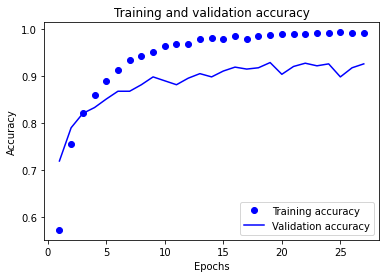

In [8]:
## Plotting accuracy
plot_acc(history)

# compare with untrained

In [9]:
untrained_model = keras.models.load_model("../../models/zenodo/m3_medium.h5")
untrained_model.evaluate(test)

 8/23 [=========>....................] - ETA: 0s - loss: 0.3215 - accuracy: 0.9258

2022-08-07 17:45:41.665489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 16ms/step - loss: 0.2399 - accuracy: 0.9417


[0.23994354903697968, 0.9416666626930237]

# All Trainable Layers Transfer Learning - start from nonrandom weights

In [10]:
vtid2_allTrainable = keras.models.load_model('../../models/vtid2/m2_medium.h5')

x = vtid2_allTrainable.layers[-2].output
outputs = keras.layers.Dense(6, activation='softmax', name='classifier')(x)
all_trainable_model = keras.Model(vtid2_allTrainable.inputs, outputs)
all_trainable_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
all_trainable_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                       

In [11]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=8
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="../../models/transfer/transfer_medium_trainFull.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]

In [12]:
history = all_trainable_model.fit(
  train.cache(),
  epochs=50,
  callbacks=callbacks_list,
  validation_data=val.cache()
)

Epoch 1/50


2022-08-07 17:45:42.467444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


104/105 [============================>.] - ETA: 0s - loss: 1.3310 - accuracy: 0.4919

2022-08-07 17:45:47.083036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 5s 46ms/step - loss: 1.3301 - accuracy: 0.4917 - val_loss: 1.0441 - val_accuracy: 0.6236
Epoch 2/50
105/105 [==============================] - 5s 46ms/step - loss: 0.7906 - accuracy: 0.7128 - val_loss: 0.9174 - val_accuracy: 0.6639
Epoch 3/50
105/105 [==============================] - 5s 49ms/step - loss: 0.5912 - accuracy: 0.7833 - val_loss: 0.6510 - val_accuracy: 0.7694
Epoch 4/50
105/105 [==============================] - 5s 46ms/step - loss: 0.4390 - accuracy: 0.8390 - val_loss: 0.6272 - val_accuracy: 0.7681
Epoch 5/50
105/105 [==============================] - 5s 45ms/step - loss: 0.3492 - accuracy: 0.8762 - val_loss: 0.4527 - val_accuracy: 0.8333
Epoch 6/50
105/105 [==============================] - 5s 47ms/step - loss: 0.2838 - accuracy: 0.9039 - val_loss: 0.9001 - val_accuracy: 0.7208
Epoch 7/50
105/105 [==============================] - 5s 46ms/step - loss: 0.2314 - accuracy: 0.9188 - val_loss: 0.2869 - val_accuracy: 0.8972
Epoch 8/50

In [13]:
trainable_model = keras.models.load_model("../../models/transfer/transfer_medium_trainFull.h5")
trainable_model.evaluate(test)

 4/23 [====>.........................] - ETA: 0s - loss: 0.2707 - accuracy: 0.9297

2022-08-07 17:48:25.405990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 1s 17ms/step - loss: 0.2629 - accuracy: 0.9417


[0.26287591457366943, 0.9416666626930237]

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/pyplot.py'>

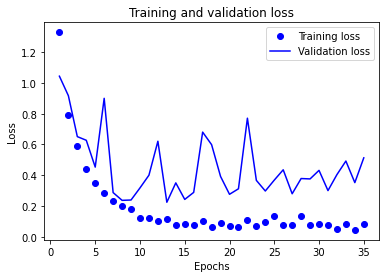

In [14]:
# Plotting loss and accuracy graphs
## Plotting loss
plot_loss(history)

<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/pyplot.py'>

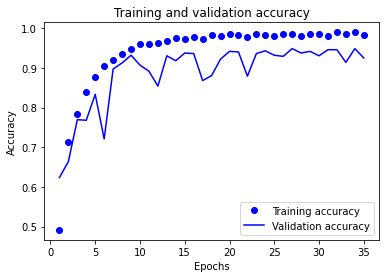

In [15]:
## Plotting accuracy
plot_acc(history)